# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# !pip install category_encoders -q
# !pip install catboost -q

In [2]:
import warnings
from pprint import pprint
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
import lightgbm as lgb
import catboost as cb

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
try:
    df = pd.read_csv('autos.csv')
except FileNotFoundError:
    df = pd.read_csv('####')

In [5]:
display(df.shape)
display(df.info())
display(df.describe())
df.head()

(354369, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В таблице есть столбцы с пропущенными значениями. Найдем эти столбцы.

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Посмотрим можно ли заполнить пропущенные значения по столбцам.

In [7]:
# Столбец VehicleType заполнить мы не можем, поскольку в нём встречаются разные модели от разных брендов.
display(df[df.VehicleType.isna()])
# В столбце Gearbox можно заполнить отсутствующие значения значением manual
display(df.Gearbox.value_counts())
ix = df[df.loc[:, 'Gearbox'].isna()].index
df.loc[ix, 'Gearbox'] = 'manual'
# Столбец model оставим с пустыми значениями
display(df.FuelType.value_counts())
display(sum(df.FuelType.isna()))
# Petrol и gasoline это одно и тоже, надо объединить категории. Пропущенные значения заполним petrol.
ix = df[df.loc[:, 'FuelType'].isna()].index
df.loc[ix, 'FuelType'] = 'petrol'
ix = df[df.loc[:, 'FuelType'] == 'gasoline'].index
df.loc[ix, 'FuelType'] = 'petrol'
# Столбец Repaired, как и VehicleType содержат большое количество пропущенных значений. Однозначно
# заполнить их мы не можем, но для обучения моделей надо что-бы данные были заполнены,
# поэтому создадим специальную категорию 'missing'.
columns = df.columns
imputer = SimpleImputer(strategy='constant', fill_value='missing')
df = imputer.fit_transform(df)
df = pd.DataFrame(df, columns=columns)
# Проверим что в данных нет пропусков
display(df.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354351,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,0,87700,2016-03-12 14:16:51
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49


Gearbox
manual    268251
auto       66285
Name: count, dtype: int64

FuelType
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

32895

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  object
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  object
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  object
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  object
 8   RegistrationMonth  354369 non-null  object
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  object
 14  PostalCode         354369 non-null  object
 15  LastSeen           354369 non-null  object
dtypes: object(16)
memory

None

In [8]:
# Конвертируем нужные столбцы в числа
df.Price = df.Price.astype(int)
df.Kilometer = df.Kilometer.astype(int)
df.RegistrationMonth = df.RegistrationMonth.astype(int)
df.RegistrationYear = df.RegistrationYear.astype(int)
df.Power = df.Power.astype(int)
# Проверка, что всё прошло нормально и мы ничего не забыли
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  object
 14  PostalCode         354369 non-null  object
 15  LastSeen           354369 non-null  object
dtypes: int64(5), object(

In [9]:
# Проверки данных на адекватность
print('-'*50 + 'Цена = 0' + '-'*50)
print(df[df.Price == 0])
print('-'*50 + 'Мощность = 0' + '-'*50)
pprint(df[df.Power == 0])
print('-'*50 + 'Мощность > 500' + '-'*50)
pprint(df[df.Power > 500])

--------------------------------------------------Цена = 0--------------------------------------------------
                DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
7       2016-03-21 18:54:38      0       sedan              1980  manual   
40      2016-03-26 22:06:17      0     missing              1990  manual   
111     2016-03-19 18:40:12      0     missing              2017  manual   
115     2016-03-20 18:53:27      0       small              1999  manual   
152     2016-03-11 18:55:53      0         bus              2004  manual   
...                     ...    ...         ...               ...     ...   
354205  2016-03-09 15:56:30      0     missing              2000  manual   
354238  2016-03-20 14:55:07      0       small              2002  manual   
354248  2016-03-24 13:48:05      0       small              1999  manual   
354277  2016-03-10 22:55:50      0       small              1999  manual   
354364  2016-03-21 09:50:58      0     missing         

Для столбцов дата регистрации и дата создания объявления построим графики.

Year
2016    354343
2015        25
2014         1
Name: count, dtype: int64
RegistrationYear
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: count, Length: 151, dtype: int64


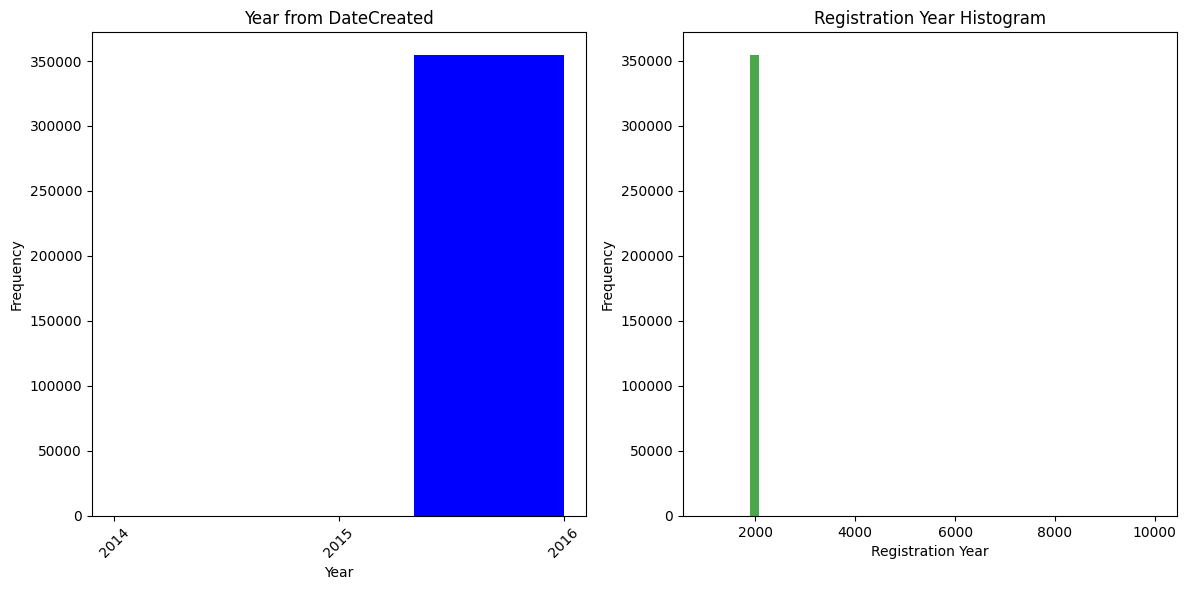

YearCrawled
2016    354343
2015        25
2014         1
Name: count, dtype: int64
60095
27743


In [10]:
# Проверка данных на адекватность часть 2
df['Year'] = pd.to_datetime(df['DateCreated']).dt.year
print(df['Year'].value_counts())
print(df['RegistrationYear'].value_counts())
# Построим графики для наглядности
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

unique_years = df['Year'].unique()
axs[0].hist(df['Year'], bins=3, color='blue', align='mid')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Year from DateCreated')
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_xticks(unique_years)


axs[1].hist(df['RegistrationYear'], bins=50, color='green', alpha=0.7)
axs[1].set_xlabel('Registration Year')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Registration Year Histogram')

plt.tight_layout()
plt.show()

# Посмотрим когда собирались данные по столбцу DateCrawled
df['YearCrawled'] = pd.to_datetime(df['DateCreated']).dt.year
print(df.YearCrawled.value_counts())
# Думаю для чистоты эксперимента надо выкинуть всё что было собрано не в 2016, 
# там всё равно 26 записей всего.

# Посмотрим сколько данных мы потеряем если удалим авто с ценой = 0, 
# мощностью = 0, мощностью > 500, годом регистрации > 2016 и датой подачи объявления > 2016
print(df.query(
    'Price == 0 or Power == 0 or Power > 500 or RegistrationYear > 2016\
    or Year < 2016 or RegistrationYear < 1980'
).shape[0])
# Посмотрим что будет если убрать из условия мощность
print(df.query(
    'Price == 0 or RegistrationYear > 2016 or Year < 2016 or RegistrationYear < 1980'
).shape[0])
# С этим уже можно жить, к удалению ~27700 записей, а мощность импутируем.

Видно что объявления подавались только в 2016 году, и собирались данные тоже в основном в 2016. Поэтому объявления где дата регистрации авто более 2016 года и меньше 1980 удалим. Также удалим объявления где дата подачи объявления не 2016 год, потому что таких только 26 штук и это подозрительно. Таким образом мы избавляемся от 10% данных. После этого импутируем столбец Power используя метод ближайших соседей.

In [11]:
# Теперь удалим записи с неполными/неверными данными
to_rem_ind = df.query(
    'Price == 0 or RegistrationYear > 2016 or Year < 2016 or RegistrationYear < 1980'
).index
df = df.drop(to_rem_ind)
# Проверим на дубликаты
df[df.duplicated(keep=False)]
# Дубликаты присутствуют, оставим только первые записи
df = df.loc[~df.duplicated(keep='last')]

In [12]:
# Импутация столбца Power
df.loc[df['Power'] > 500, 'Power'] = np.nan
df['Power'].replace(0, np.nan, inplace=True)
features = df.drop(['Power'], axis=1)
target = df['Power']

knn_imputer = KNNImputer(n_neighbors=3)
imputed_power = knn_imputer.fit_transform(target.values.reshape(-1, 1)).ravel()
df['Power'] = imputed_power

Перейдем к удалению лишних столбцов.

In [13]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen',
       'Year', 'YearCrawled'],
      dtype='object')

In [14]:
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'NumberOfPictures', 'LastSeen',
              'Year', 'YearCrawled'], 
             axis=1)

На этапе предобоработки данных мы познакомились с данными, удалили лишние столбцы и заполнили пропуски.

## Обучение моделей

Подготовим данные для обучения моделей. Столбцы с категориальным переменными необходимо закодировать с помощью фиктивных переменных.

In [15]:
# Подготовка данных
X = df.drop('Price', axis=1)
y = df['Price']

all_cols = X.columns

# Создадим список столбцов которые надо закодировать
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Трансформатор для столбцов, поскольку нам надо проверить модель случайного леса, а она не терпит категориальных значений.
preprocessor_cols = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', ce.BinaryEncoder(), categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor_cols.fit_transform(X_train)
X_test = preprocessor_cols.transform(X_test)

print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

261297 65325 261297 65325


Приступим к тренировке моделей.

In [16]:
# Набор гиперпараметров
lgb_params = {
    'n_estimators': [150, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'random_state': [42]
}

# Инициализация модели
lgb_model = lgb.LGBMRegressor()

# Инициализуем GridSearchCV
grid = GridSearchCV(lgb_model, lgb_params, cv=5, scoring='neg_root_mean_squared_error')

# Нахождение лучших параметров
start_time = time.time()
grid.fit(X_train, y_train)
lgb_learning_time = time.time() - start_time

# Вытаскиваем лучший набор параметров
best_params = grid.best_params_

# Тренируем модель на лучших параметрах
start_time = time.time()
lgb_model = lgb.LGBMRegressor(**best_params)
lgb_model.fit(X_train, y_train)
lgb_learning_time_2 = time.time() - start_time

# Делаем предсказание и рассчитываем RMSE
start_time = time.time()
lgb_predictions = lgb_model.predict(X_test)
lgb_prediction_time = time.time() - start_time
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))

# Статистика для модели LightGBM
print('LightGBM Model:')
print(f'Best Parameters: {best_params}')
print(f'Best Parameters Finding Time: {lgb_learning_time:.6f} seconds')
print(f'Root Mean Squared Error (RMSE): {lgb_rmse:.4f}')
print(f'Learning Time: {lgb_learning_time_2:.6f} seconds')
print(f'Prediction Time: {lgb_prediction_time:.6f} seconds')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 209037, number of used features: 29
[LightGBM] [Info] Start training from score 4591.165368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 209037, number of used features: 29
[LightGBM] [Info] Start training from score 4582.030282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [17]:
# Набор гиперпараметров
cat_params = {
    'iterations': [150, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [5, 7],
    'random_state': [42]
}

# Инициализация модели
cat_model = cb.CatBoostRegressor(verbose=0)

# Инициализуем GridSearchCV
grid = GridSearchCV(cat_model, cat_params, cv=5, scoring='neg_root_mean_squared_error')

# Нахождение лучших параметров
start_time = time.time()
grid.fit(X_train, y_train)
cat_learning_time = time.time() - start_time

# Вытаскиваем лучший набор параметров
best_params = grid.best_params_

# Тренируем модель на лучших параметрах
start_time = time.time()
cat_model = cb.CatBoostRegressor(**best_params)
cat_model.fit(X_train, y_train)
cat_learning_time_2 = time.time() - start_time

# Делаем предсказание и рассчитываем RMSE
start_time = time.time()
cat_predictions = cat_model.predict(X_test)
cat_prediction_time = time.time() - start_time
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_predictions))

# Статистика для модели CatBoost
print('CatBoost Model:')
print(f'Best Parameters: {best_params}')
print(f'Best Parameters Finding Time: {cat_learning_time:.6f} seconds')
print(f'Root Mean Squared Error (RMSE): {cat_rmse:.4f}')
print(f'Learning Time: {cat_learning_time_2:.6f} seconds')
print(f'Prediction Time: {cat_prediction_time:.6f} seconds')

0:	learn: 4226.7880495	total: 104ms	remaining: 20.8s
1:	learn: 3959.9070222	total: 224ms	remaining: 22.2s
2:	learn: 3718.7649762	total: 330ms	remaining: 21.7s
3:	learn: 3509.8288748	total: 566ms	remaining: 27.7s
4:	learn: 3328.2309882	total: 655ms	remaining: 25.5s
5:	learn: 3165.4269741	total: 834ms	remaining: 27s
6:	learn: 3022.3376757	total: 992ms	remaining: 27.3s
7:	learn: 2897.1180141	total: 1.17s	remaining: 28s
8:	learn: 2790.5769651	total: 1.27s	remaining: 26.9s
9:	learn: 2693.6676577	total: 1.39s	remaining: 26.4s
10:	learn: 2609.0606601	total: 1.49s	remaining: 25.6s
11:	learn: 2535.6764221	total: 1.59s	remaining: 24.9s
12:	learn: 2474.3444025	total: 1.71s	remaining: 24.6s
13:	learn: 2419.0586249	total: 1.82s	remaining: 24.1s
14:	learn: 2367.6706760	total: 1.96s	remaining: 24.1s
15:	learn: 2325.7417475	total: 2.11s	remaining: 24.3s
16:	learn: 2282.5415403	total: 2.28s	remaining: 24.5s
17:	learn: 2249.4886885	total: 2.43s	remaining: 24.6s
18:	learn: 2220.7030869	total: 2.54s	remai

In [18]:
# Набор гиперпараметров
rf_params = {
    'n_estimators': [50, 70],
    'max_depth': [5, 7],
    'random_state': [42]
}

# Инициализация модели
rf_model = RandomForestRegressor()

# Инициализуем GridSearchCV
grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_root_mean_squared_error')

# Нахождение лучших параметров
start_time = time.time()
grid.fit(X_train, y_train)
rf_learning_time = time.time() - start_time

# Вытаскиваем лучший набор параметров
best_params = grid.best_params_

# Тренируем модель на лучших параметрах
start_time = time.time()
rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train, y_train)
rf_learning_time_2 = time.time() - start_time

# Делаем предсказание и рассчитываем RMSE
start_time = time.time()
rf_predictions = rf_model.predict(X_test)
rf_prediction_time = time.time() - start_time
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

# Статистика для модели Random Forest
print('Random Forest Model:')
print(f'Best Parameters: {best_params}')
print(f'Best Parameters Finding Time: {rf_learning_time:.6f} seconds')
print(f'Root Mean Squared Error (RMSE): {rf_rmse:.4f}')
print(f'Learning Time: {rf_learning_time_2:.6f} seconds')
print(f'Prediction Time: {rf_prediction_time:.6f} seconds')

Random Forest Model:
Best Parameters: {'max_depth': 7, 'n_estimators': 70, 'random_state': 42}
Best Parameters Finding Time: 1283.458965 seconds
Root Mean Squared Error (RMSE): 2125.1871
Learning Time: 51.676700 seconds
Prediction Time: 0.233156 seconds


Попробуем применить линейную регрессию с градиентным спуском, в образовательных целях напишу класс самостоятельно.

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Время нахождения лучших параметров: 799.6717340946198
Лучшие параметры: {'learning_rate': 0.1, 'n_iterations': 1000}
Лучшая перекрёстная ошибка RMSE: 2871.255232747477
Время тренировки модели: 35.81499433517456
Время предсказания: 0.014445304870605469
Ошибка RMSE на тестовом наборе: 2872.995238515296


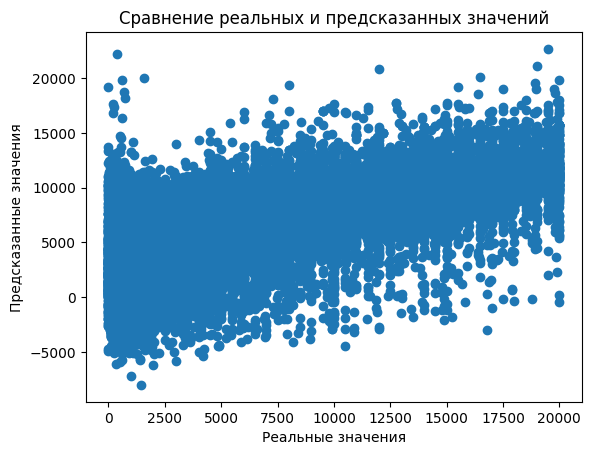

In [19]:
# Определение класса LinearRegressionGD
class LinearRegressionGD(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.n_iterations):
            model_predictions = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (model_predictions - y))
            db = (1 / n_samples) * np.sum(model_predictions - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        return self

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def score(self, X, y):
        predictions = self.predict(X)
        mse = mean_squared_error(y, predictions)
        rmse = np.sqrt(mse)
        return -rmse  # Используется отрицательный RMSE для GridSearchCV

# Определение сетки параметров для поиска
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_iterations': [100, 500, 1000]
}

# Создание и выполнение GridSearchCV
grid_search = GridSearchCV(LinearRegressionGD(), param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
start_time = time.time()
grid_search.fit(X_train, y_train)
grid_time = time.time() - start_time
print(f"Время нахождения лучших параметров: {grid_time}")

# Вывод лучших параметров и соответствующей оценки
print(f"Лучшие параметры: {grid_search.best_params_}")
best_rmse = -grid_search.best_score_
print(f"Лучшая перекрёстная ошибка RMSE: {best_rmse}")

# Повторное обучение модели с лучшими параметрами на полном наборе данных
best_model = grid_search.best_estimator_
start_time = time.time()
best_model.fit(X_train, y_train)
model_train_time = time.time() - start_time
print(f"Время тренировки модели: {model_train_time}")

# Предсказания с настроенной моделью
start_time = time.time()
predictions = best_model.predict(X_test)
prediction_time = time.time() - start_time
print(f"Время предсказания: {prediction_time}")

# Расчёт и вывод метрик производительности
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Ошибка RMSE на тестовом наборе: {rmse}")

# Визуализация реальных значений по сравнению с предсказанными
plt.scatter(y_test, predictions)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение реальных и предсказанных значений')
plt.show()

## Анализ моделей

LightGBM Model:
- Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42}
- Best Parameters Finding Time: 220.682484 seconds
- Root Mean Squared Error (RMSE): 1712.2346
- Learning Time: 5.797926 seconds
- Prediction Time: 1.001701 seconds

CatBoost Model:
- Best Parameters: {'depth': 7, 'iterations': 200, 'learning_rate': 0.1, 'random_state': 42}
- Best Parameters Finding Time: 434.741581 seconds
- Root Mean Squared Error (RMSE): 1678.4958
- Learning Time: 15.733941 seconds
- Prediction Time: 0.083841 seconds

RandomForest Model:
- Best Parameters: {'max_depth': 7, 'n_estimators': 70, 'random_state': 42}
- Best Parameters Finding Time: 1283.458965 seconds
- Root Mean Squared Error (RMSE): 2125.1871
- Learning Time: 51.676700 seconds
- Prediction Time: 0.233156 seconds

LinearRegressionGB Model:
- Best Parameters: {'learning_rate': 0.1, 'n_iterations': 1000}
- Best Parameters Finding Time: 799.6717340946198 seconds
- Root Mean Squared Error (RMSE): 2872.995238515296
- Learning Time: 35.81499433517456 seconds
- Prediction Time: 0.014445304870605469 seconds

__Вывод__:
Имея вводные, что заказчику важны качество предсказания, скорость предсказания и время обучения я бы посоветовал выбрать модель на основе CatBoost. Так как у неё самое точное предсказание, приемлемая скорость обучения и время предсказания всего 0.08 секунды. По скорости предсказания её обходит только самописная модель линейной регрессии с 0.014 секунды, но она в 2 раза проигрывает по точности предсказания. Второй хороший кандидат это модель на основе LightGBM, она немного уступает в точности и скорости предсказания, зато в 3 раза быстрее обучается. Показатели у модели на основе случайного леса средние.